# Fourier Series

Useful documentation for various things used here:

https://docs.sympy.org/latest/tutorial/calculus.html

https://www.tutorialspoint.com/sympy/sympy_plotting.htm

https://docs.sympy.org/latest/modules/plotting.html#plotgrid-class

https://docs.sympy.org/latest/modules/series/fourier.html

This file contains code that defines a reasonably fast and flexible Fourier Series class. It calculates the series analytically with sympy, and then uses numpy to evaluate it reasonably quickly numerically to create plots and sound files. To get an idea of what it does, I recommend scrolling past the code to the examples in the first instance.

Have fun! 

Jonas Rademacker

In [1]:
from sympy import *
import matplotlib.pyplot as plt
init_session()
init_printing(use_unicode=True)

import seaborn as sns
sns.set()
sns.set_style("whitegrid", {'grid.linestyle': '--'})

from IPython.display import display, Math, Latex, Audio

from time import sleep

# remove/comment line below to get plots in a seperate window
%matplotlib inline

IPython console for SymPy 1.6.1 (Python 3.8.3-64-bit) (ground types: gmpy)

These commands were executed:
>>> from __future__ import division
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.6.1/



In [2]:
# This class holds a function that may in fact be periodic or not, and creates
# x and y numpy arrays for plotting it over one single period. To create multiple
# periods, this gets repeated and stiched together further down in the FourierSeries
# class.
class periodicFunction:
    def __init__(self, fc, shortName="", periodify=(-pi, pi), variable=t):

        self.fc     = fc
        self.name   = latex(self.fc)
        self.shortName = shortName
        
        self.p0     = np.float32(periodify[0]) 
        self.p1     = np.float32(periodify[1]) 
        self.T      = self.p1 - self.p0
        self.var    = variable
        
        self.lfc    = lambdify(self.var, self.fc, "numpy")
        
        self.xvalues  = np.empty(0)
        self.yvalues  = np.empty(0)

    def getFc(self):
        return self.fc
    
    def getString(self, maxLength=-1):
        if maxLength > 0 and len(self.name) > maxLength:
            return self.shortName
        else:
            return self.name
        
    # duplication because matplotlib legend likes dollars, while...
    def getLegend(self, maxLength=-1):
        return '$' + self.getString(maxLength) + '$'
    # ... github renders only with \\( \\)
    def getLatex(self, maxLength=-1):
        return '\\(' + self.getString(maxLength) + '\\)'
    
    def makeOnePeriod(self, Npoints=1000):
        xvalues=np.arange(self.p0, self.p1, self.T/Npoints)
        yvalues=None
        if self.fc.is_constant(): # then lambdified function does not return array
            yvalues=0*xvalues+fc[0].evalf()
        else:
            yvalues=self.lfc(xvalues)
        return xvalues, yvalues


In [3]:
# This class holds a fourier series - including the evaluated x, y arrays for plotting 
# (or playing as sound) for one single period.
class FourierS:
    def __init__(self, stringFct, periodify=(-pi, pi), variable=t, Npoints=1000
                 , even=False, odd=False
                 ):
        
        self.f      = sympify(stringFct)
        self.limits = (variable, periodify[0], periodify[1])
        self.Ls     = periodify[1] - periodify[0]
        
        self.p0     = np.float32(periodify[0]) 
        self.p1     = np.float32(periodify[1]) 
        self.Ln     = self.p1-self.p0
        
        self.omegas = 2*pi/self.Ls  #...s for sympy objects
        self.omegan = 2*pi/self.Ln  #...n for numpy

        self.ansArray = np.empty(0)
        self.bnsArray = np.empty(0)
        self.annArray = np.empty(0)
        self.bnnArray = np.empty(0)
        
        self.N = Npoints
        self.xArray   = np.arange(self.p0, self.p1, self.Ln/self.N)
        self.alen     = len(self.xArray)
        self.cosArray = np.zeros((0, self.alen))
        self.sinArray = np.zeros((0, self.alen))
        self.even     = even
        self.odd      = odd
        self.variable = variable
        
        self.onePeriod = {}
        
    def make_cos(self,i):
        self.cosArray[i]=np.cos(i*2*np.pi*self.xArray/self.Ln)
    def make_sin(self,i):
        np.copyto(self.sinArray[i],np.sin(i*2*np.pi*self.xArray/self.Ln))
        
    def append_an(self, n):
        l =len(self.ansArray)
        if n<l: return
        self.ansArray=np.append(self.ansArray, np.full(n-l+1, sympify('0')))
        self.annArray=np.append(self.annArray, np.zeros(n-l + 1))

        self.cosArray=np.append(self.cosArray, np.zeros((n-l + 1,self.alen)), axis=0)

        for i in range(l, n+1):
            self.make_an(i)
            self.make_cos(i)
                                
    def append_bn(self, n):
        l = len(self.bnsArray)
        if n<l: return
        self.bnsArray=np.append(self.bnsArray, np.full(n-l+1, sympify('0')))
        self.bnnArray=np.append(self.bnnArray, np.zeros(n-l + 1))

        self.sinArray=np.append(self.sinArray, np.zeros((n-l + 1,self.alen)), axis=0)

        for i in range(l, n+1):
            self.make_bn(i)
            self.make_sin(i)
                                
    def make_an(self, i):
        if self.odd:
            return None
        if i == 0:
            costerm = 1/2
        else:
            costerm      = cos(i*self.omegas*self.variable)
        self.ansArray[i] = (2/self.Ls)*integrate(self.f * costerm, self.limits)
        self.annArray[i] = self.ansArray[i].evalf()
                        
    def make_bn(self, i):
        if i == 0:
            return None
        if self.even:
            return None
        sinterm          = sin(i*self.omegas*self.variable)
        self.bnsArray[i] = (2/self.Ls)*integrate(self.f * sinterm, self.limits)
        self.bnnArray[i] = self.bnsArray[i].evalf()  
        
    def ans(self, n):
        l=len(self.ansArray)
        if(l <= n):
            self.append_an(n)
        return self.ansArray[n]
    
    def ann(self, n):
        l=len(self.annArray)
        if(l <= n):
            self.append_an(n)
        return self.annArray[n]
    
    def bns(self, n):
        l=len(self.bnsArray)
        if(l <= n):
            self.append_bn(n)
        return self.bnsArray[n]

    def bnn(self, n):
        l=len(self.bnnArray)
        if(l <= n):
            self.append_bn(n)
        return self.bnnArray[n]
    
    def do(self, n):
        self.ann(n)
        self.bnn(n)
        
    def plotSin(self,n):
        self.ann(n)
        plt.plot(self.xArray, self.sinArray[n+1])
        
    def plotCos(self,n):
        self.bnn(n)
        plt.plot(self.xArray, self.cosArray[n+1])

    def complexCoefficients(self, n):
        if(n not in self.onePeriod):
            self.do(n)
            
        a0 = np.array([2*self.annArray[0],])
        Recn = np.append( np.flip(self.annArray[1:n+1]), a0)
        Recn = 0.5*np.append(Recn, self.annArray[1:n+1])
        # acrobatics with the 2*self.annArray[0] necessary because annArray[0] holds a0/2, not a0.
        Imcn = 0.5*np.append(-np.flip(self.bnnArray[:n+1]), self.bnnArray[1:n+1])
        
        return Recn, Imcn
    
    def plotCoefficients(self, n=-1, optx="omega", opty="cn"):
        if n < 0:
            n=len(self.bnnArray) # plot those you already calculated
            
        if n not in self.onePeriod:
            self.do(n)
        
        xfactor=1
        label  ='n'
        if optx == "f" or optx == "frequency":
            xfactor = 1/self.Ln
            label   = "frequency"
        elif optx == "omega" or optx == "angular frequency":
            xfactor = 2*np.pi/self.Ln
            label   = "angular frequency"
        elif optx == "n":
            xfactor = 1
            label   = "n"
            
        narray=np.arange(n+1)*xfactor
        if opty == "cos" or opty == "an" or opty == "both":
            a0 = np.array([2*self.annArray[0],])  # annArray[0] holds a0/2, not a0
            plt.step(narray, np.append(a0, self.annArray[1:n+1]), label="$a_n$", where='mid')
        if opty == "sin" or opty == "bn" or opty == "both":
            plt.step(narray, self.bnnArray[:n+1], label="$b_n$", where='mid')
        if opty == "Recn" or opty == "Imcn" or opty == "cn" or opty == "|cn|":
            pmnarray=np.arange(-n, (n+1))*xfactor
            Recn, Imcn = self.complexCoefficients(n)
        if opty=="Recn" or opty=="cn":
            plt.step(pmnarray, Recn, label = "$Re(c_n)$", where='mid')
        if opty=="Imcn" or opty=="cn":
            plt.step(pmnarray, Imcn, label = "$Im(c_n)$", where='mid')
        if opty=="|cn|": # magnitude of complex coefficients
            plt.step(pmnarray, sqrt(Recn**2 + Imcn**2), where='mid')

        plt.xlabel(label)
        plt.ylabel("Fourier Coefficient")
        plt.legend()
        plt.show()
    
    def makeOnePeriod(self,n):
        # this is where all the x, y arrays for the sines and cosines 
        # are multiplies with the bn and an coefficents and then 
        # added together in one single numpy matrix multiplication
        # which makes this quite fast
        if(n not in self.onePeriod):
            self.do(n)
            self.onePeriod[n]=(np.matmul(self.annArray[:n+1], self.cosArray[:n+1]) + 
                               np.matmul(self.bnnArray[:n+1], self.sinArray[:n+1]))
        return self.xArray, self.onePeriod[n]
    
    def getFormula(self, n, startAt=0):
        self.do(n)
        string=""
        zero=sympify('0')
        sums=zero
        for i in range(startAt, n+1):
            sums += simplify(self.ansArray[i] * cos((2*i*pi/self.Ls) * self.variable))
            sums += simplify(self.bnsArray[i] * sin((2*i*pi/self.Ls) * self.variable))
            if i == startAt: simplify(sums)
        return sums
    
    def getString(self, n, startAt=0):
        return str(latex(self.getFormula(n, startAt)))


In [4]:
# This class combines periodicFunction and the FourierS defined above, and adds various
# ways of plotting them and creating sound files from them.
class FourierSeries:
    def __init__(self, stringFct, periodify=(-pi, pi), plotrange=(-10, 10), variable=t
                 , Npoints=1000, baseFrequency=220, sr=88000, audioTime=4):
        
        # I seem to need this excessive-seeming sampling rate (22,000 should do for the human ear)
        # in order to get the original and the high-order fourier to sound the same.
        # I presume it's an artefact of how these sounds are generated.
        
        self.variable = variable
        
        self.p0     = np.float32(periodify[0]) 
        self.p1     = np.float32(periodify[1]) 
        
        self.plotrange = plotrange
        self.plotTime  = self.plotrange[1] - self.plotrange[0]
        
        self.Taudio = 1/baseFrequency
        self.Tplot  = self.p1-self.p0
        
        self.audioTime=audioTime
        
        self.sr = sr
        self.NpointsAudio = int(self.Taudio*self.sr)+1
        self.NpointsPlot  = Npoints
        
        # below the three function objects: f, the original, and two Fourier Series
        # one for plotting and one for audio (audio cannot digest the number of points
        # needed for a good plot, hence the split into two objects)
        self.f      = periodicFunction(fc=sympify(stringFct), periodify=periodify, variable=variable)
        self.Splot  = FourierS(stringFct, periodify, variable, self.NpointsPlot)
        self.Saudio = FourierS(stringFct, periodify, variable, self.NpointsAudio)
        
        self.xplotF  = np.empty(0)
        self.yplotF  = np.empty(0)
        self.yaudioF = np.empty(0)
        
        self.xplotS  = {}
        self.yplotS  = {}
        self.yaudioS = {}
        
        self.audioObjects = {}  # object -1 is for f
        
        self.makeLongFArrays()
        
    #  periodic function and FourierS produce x and y arrays of one period
    #  the methods below are for plotting and listening to multiple periods
    def adjustPlotRange(self, xvalues, yvalues):
        # moves starting point to the desired value of t0 - assumes that there are 
        # two extra periods in the file so we can move things beyond the edges (see below)
        t0 = self.plotrange[0]
        dt              = (xvalues[-1]-xvalues[0])/len(xvalues)
        tshift          = int((t0 - xvalues[0])/self.Tplot)*self.Tplot - self.Tplot # shift by one extra period downwards
        nshift          = int(tshift/dt + 0.5)
        shiftedXvalues  = xvalues + nshift*dt
        shiftedYvalues  = np.roll(yvalues, nshift)

        return shiftedXvalues, shiftedYvalues

    def makeLongArrayPair(self, onePeriod_x, onePeriod_y, T, time):
        # Stitches together multiple copies single-period arrays with x, y values to a 
        # full plot or sound files
        N       = int(time/T+0.5)+2 # two extra periods will help with the above adjustments
        xvalues = np.empty(0)
        yvalues = np.empty(0)
        for n in range(N):
            xvalues = np.append(xvalues,onePeriod_x + n*T)
            yvalues = np.append(yvalues,onePeriod_y)
        return xvalues, yvalues

    def makeLongFArrays(self):
        # Stitches together the single-period function numpy x, y arrays to full plots and sound arrays
        FaudioX, FaudioY = self.f.makeOnePeriod(self.NpointsAudio)
        dummy, self.yaudioF = self.makeLongArrayPair(FaudioX, FaudioY, self.Taudio, self.audioTime)
        self.audioObjects[-1] = Audio(self.yaudioF, rate=self.sr)
        
        oneX, oneY  = self.f.makeOnePeriod(self.NpointsPlot)
        longx, longy   = self.makeLongArrayPair(oneX, oneY, self.Tplot, self.plotTime)
        self.xplotF, self.yplotF = self.adjustPlotRange(longx, longy)

    def makeLongSAudioArrays(self, n):
        # Stitches together the single-period Fourier series numpy arrays to a full sound array
        if n<0: return
        SaudioX, SaudioY       = self.Saudio.makeOnePeriod(n)
        dummy, self.yaudioS[n] = self.makeLongArrayPair(SaudioX, SaudioY, self.Taudio, self.audioTime)
        #print("long audio array",n, self.yaudioS[n])
        self.audioObjects[n] = Audio(self.yaudioS[n], rate=self.sr)
        
    def makeLongSPlotArrays(self, n):
        # Stitches tother the single-period Fourier series numpy arrays to a full plot
        oneX, oneY     = self.Splot.makeOnePeriod(n)
        longx, longy   = self.makeLongArrayPair(oneX, oneY, self.Tplot, self.plotTime)
        self.xplotS[n], self.yplotS[n] = self.adjustPlotRange(longx, longy)
        
    def seriesString(self, n, maxL=-1):
        # creates the mathematical expression for the nth order Fourier series
        # as a0/2 + a1 cos(x) + b1 sin(x) + ... + an cos(nx) + bn sin(nx)
        # If n<0, it just represents the expression for the original function.
        # maxL determins the maximum order before it will abbreviate the string

        if maxL < 0 or n < maxL: return self.Splot.getString(n)
        return self.Splot.getString(maxL) + " + \\ldots + " + self.Splot.getString(n, startAt=n-3)
                     
    def seriesLegend(self, n, maxL=-1):
        # the above for use in matplotlib legends - that likes $ for math
        return '$' + self.seriesString(n, maxL) + '$'
    
    def seriesLatex(self, n, maxL=-1):
        # the above with \( \) aroudn it - on github, the math doesn't render with $
        return '\\(' + self.seriesString(n, maxL) + '\\)'
    
    def getString(self, n, maxL=-1):        
        # creates f(x) \approx a0/2 + a1 cos(x) + b1 sin(x) + ... + an cos(nx) + bn sin(nx)
        if(n < 0): return self.f.getString()
        return str(self.f.getString() + " \\approx " + self.seriesString(n, maxL))
    
    def getLegend(self, n, maxL=-1):
        # same as above with dollar signs around it
        return '$' + self.getString(n, maxL) + '$'
    
    def getLatex(self, n, maxL=-1):
        # same as above with dollar \( \) around it - on github it doesn't render with $
        return '\\(' + self.getString(n, maxL) + '\\)'
    
    def printMath(self, n, maxL=-1):
        display(Latex(self.getLatex(n, maxL)))
    
    def basicPlot(self,n=-1):
        # plots the nth order approximation of the Fourier series.
        # if n < 0, it plots the original function
        if(n < 0):
            plt.plot(self.xplotF, self.yplotF, label=self.f.getLegend())
        else:
            if n not in self.xplotS:
                self.makeLongSPlotArrays(n)
            plt.plot(self.xplotS[n], self.yplotS[n], label=self.seriesLegend(n, maxL=5))
        plt.xlim((self.plotrange[0], self.plotrange[1]))
        plt.xlabel(latex(self.variable))
        plt.ylabel("amplitude")

        
    def plot(self, n=-1, sound=True):
        # plot the original function and the nth order approximation of 
        # the Fourier Series superimposed on top of it
        # I n=-1, it only plots the original function.
        self.printMath(n, maxL=10)
        plt.subplots(figsize=(10,6))
        self.basicPlot(-1)
        if sound: display(self.getAudio(-1))
        if n < 0:
            plt.show()
            return
        
        self.basicPlot(n)
        if sound: display(self.getAudio(n))
        
        plt.show()
        
    def multiPlot(self, n, start=1, step=1, allInOne=False, sound=True):
        # plots the original function and increasingly high orders of the
        # fourier series, and the corresponding sound files.
        # If "allInOne" is true, all the plots are super-imposed in 
        # a single file, and the audio version plays a progression 
        # of the Fourier series from lower to higher orders.
        
        if n>=0: self.Splot.do(n)
        
        plt.subplots(figsize=(10,6))
        self.printMath(-1)
        self.basicPlot(-1)
        if sound: display(self.getAudio(-1))

        #if sound: self.audio(-1)
        zero = sympify('0')
        for i in range(start, n+1, step):
            if step == 1 and self.Splot.ans(i) == zero and self.Splot.bns(i) == zero:
                # skip plots where there's not change (but only if incement is 1)
                continue
            if not allInOne:
                plt.show()
                plt.subplots(figsize=(10,6))
                print("_____________________________________")
                self.printMath(i, maxL=5)
                if sound and i > 0: display(self.getAudio(i))
                self.basicPlot(-1)
            self.basicPlot(i)
        if allInOne:
            self.printMath(n, maxL=5) 
            display(self.audioProgression(n=n, start=start, step=step))
        plt.show()
        
    def plotCoefficients(self, n, optx="omega", opty="cn"):
        plt.subplots(figsize=(10,6))
        return self.Splot.plotCoefficients(n, optx, opty)

    def getAudio(self, n=-1):
        # creates an audio file for the nth order Fourier series
        # n = -1 refers to the original function
        if n not in self.audioObjects:
            if n >= 0:
                self.makeLongSAudioArrays(n)
        return self.audioObjects[n]
    
    def audio(self, n=-1):
        # shows an audio file in the jupyter notebook
        display(Latex(self.getLatex(n, maxL=5)), self.getAudio(n))
    
    def multiAudio(self, n, start=1, step=1):
        # creates audio files for increasingly high orders
        # of the Fourier series
        self.Saudio.do(n)
        for i in range(start, n+1, step):
            self.audio(i)
    
    def audioProgression(self, n, start=1, step=1, time=1, totalTime=-1):
        # creates and audio file that successively plays 
        # increasingly high orders of the Fourier series
        # each with time "time".
        
        self.Saudio.do(n)
        if totalTime > 0:
            Nsteps = (n-start)/step
            if Nsteps <= 0: Nsteps=1
            time = totalTime/Nsteps
        
        # Below I calculate the number of points of each part of
        # the series. By using an integer number of periods, I make sure
        # that there are not discontinuities where the different
        # arrays are stitched together. If you uncomment the previous
        # version, N=int(Npa*time/self.audioTime+0.5),
        # you'll find these discontinuities quite audible.
        Npa=len(self.yaudioF)
        NumPeriods   = int(time/self.Taudio)+1 
        N = self.NpointsAudio * NumPeriods
        #N=int(Npa*time/self.audioTime+0.5)
        #print("N", N)
        if N >= Npa:
            N=Npa-1

        zero = sympify('0')
        progression=np.empty(0)
        
        for i in range(start, n+1, step):
            if step == 1 and self.Splot.ans(i) == zero and self.Splot.bns(i) == zero:
                # skip steps where there's not change (but only if increment is 1)
                continue
            self.getAudio(i)
            progression=np.append(progression,self.yaudioS[i][:N])
            
        return Audio(progression, rate=self.sr)
    
    def showAudioProgression(self, n, start=1, step=1, time=1, totalTime=-1):
        display(Latex(self.getLatex(n, maxL=5)), self.audioProgression(n, start, step, time, totalTime))
            


## Square Wave
The following few fields look at a square wave

We implement a square wave using the sign(t) function which gives -1 for negative t and +1 for positive t. The class will evaluate this between -pi and pi (that's what the "periodify" tells it to do), and then repeat it periodically. Note that this way of defining it means that it's an odd function, $f(-x) = -f(x)$.

<IPython.core.display.Latex object>

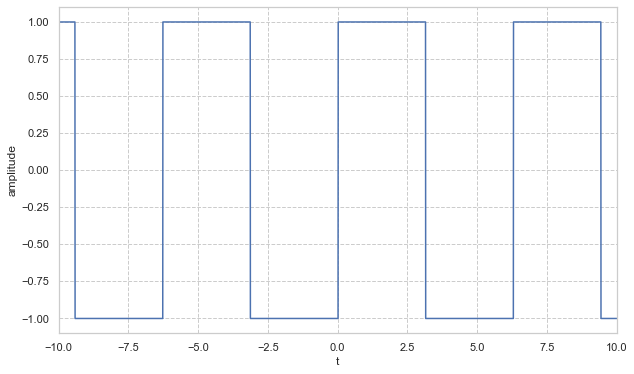

In [5]:
Square=FourierSeries("sign(t)", periodify=(-pi, pi), variable=t, baseFrequency=220)
Square.plot()

Now let's look at the function and its approximation, where we successively add sine waves $ b_n \sin(n t) $. Since we defined our square wave such that it's an odd function, i.e. $f(-x) = -f(x)$, there won't be cosines in its Fourier series. Note that you can also listen to the sound that the original function and the approximations make. As a base frequency, I chose 220Hz, so while the plots are for $b_n \sin(nt)$ (where t has no units), the sounds are for $ b_n \sin(220 Hz\cdot n \cdot t) $ with t in seconds.

<IPython.core.display.Latex object>

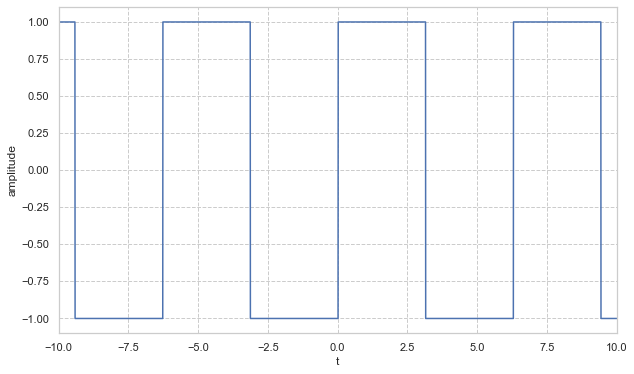

_____________________________________


<IPython.core.display.Latex object>

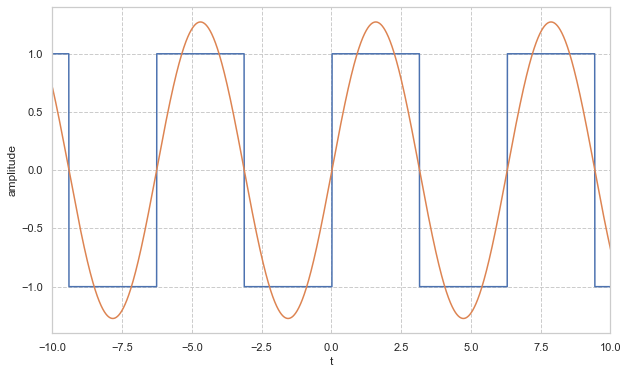

_____________________________________


<IPython.core.display.Latex object>

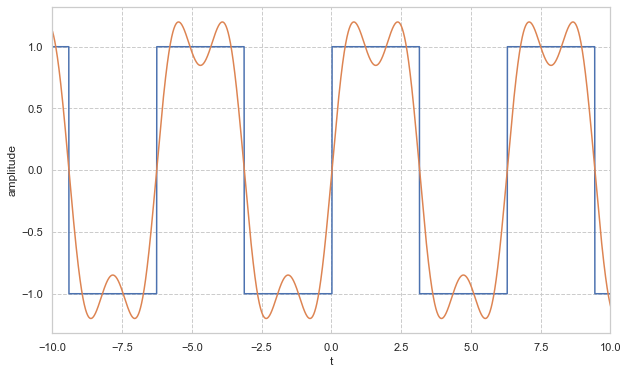

_____________________________________


<IPython.core.display.Latex object>

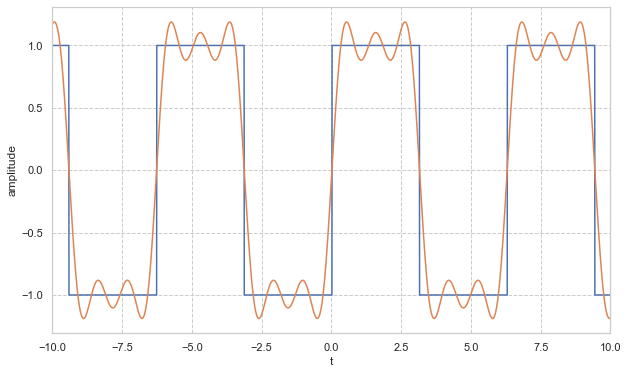

_____________________________________


<IPython.core.display.Latex object>

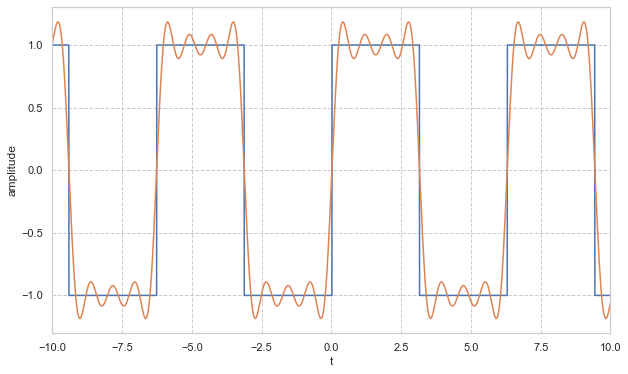

_____________________________________


<IPython.core.display.Latex object>

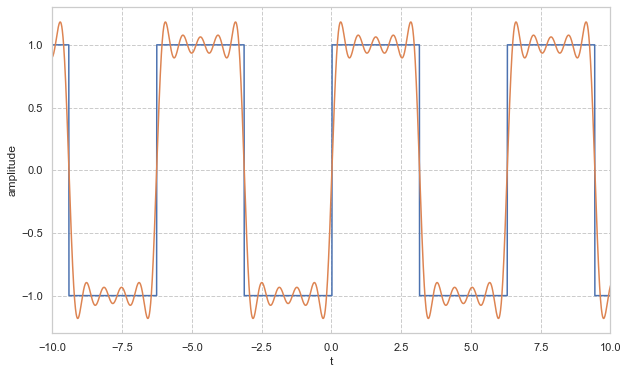

In [6]:
Square.multiPlot(10)

Let's progress a bit faster by plotting the series up to $n=100$ in steps of 20

In [ ]:
Square.multiPlot(100, start=20, step=20)

And how about n=400? We've long lost the ability to hear the difference, but you can still see the significant differences to the original function, especially near the discontinuities:

In [ ]:
Square.plot(400)

... and $n = 800$?

In [ ]:
Square.plot(800)

... still has little ears around the discontinuities.

### Audible Fourier Convergence
The first of the two sound files below is the sound of the original square wave function, and the second represents various partial sums $S_n$ of its Fourier series $S_n = \frac{a_0}{2} + \sum\limits_{k=1}^n a_k \cos(2 k \pi \cdot 220Hz \cdot t)+ \sum\limits_{k=1}^n b_k \sin(2 k \pi \cdot 220Hz \cdot t)$. Note that, because our square wave is an odd function, $a_k=0 \;\forall\;k$, and we only get sine waves. The sound starts with $n=1$ (a single sine wave) and goes up to $n=100$. It progresses by adding one non-zero sine wave component per second. Because for this particular function, $b_k$ are non-zero only for odd $k$, the frequency that gets added is $ 220Hz \cdot (2 k_s + 1) $, where $ k_s $ is the number of seconds. 

When do you stop hearing a difference? And: are we really hearing convergence, or just the limits of the human ear's frequency spectrum?

In [ ]:
Square.audio()
Square.showAudioProgression(100, time=1)

## Fourier Coefficients
The following shows the fourier coefficients as a function of frequency, i.e. it is $f_n = \frac{n}{T} $ with $T = 2\pi$, and on the y-axis it is $ a_n, b_n $. Because in this case, the function is odd, $f(-x) = -f(x)$, the series is a pure sine wave series and all the $a_n$ terms are zero.

In [ ]:
Square.plotCoefficients(50, optx="frequency", opty="both")

Equivalently, we can plot the real and imaginary part of the $c_n$ coefficients of the complex Fourier series (since this is a pure sine expansion, the real parts will all be zero).

In [ ]:
Square.plotCoefficients(50,optx="frequency", opty="cn")

## Parabolas
Here the original function is a sequence of parabolas

In [ ]:
Parabolas=FourierSeries("-(x-pi)*(x+0)", variable=x, periodify=(0,pi))

In [ ]:
Parabolas.multiPlot(20, allInOne=True)

## Triangle wave

In [ ]:
Triangle=FourierSeries("sign(t)*t")

In [ ]:
Triangle.plot(3)

## Sawtooth wave

In [ ]:
Sawtooth=FourierSeries("t")

In [ ]:
Sawtooth.multiPlot(12, step=4)

## From Fourier Series to Fourier Transform
Below we illustrate the progression from a Fourier series with its discrete frequency components to a Fourier transform with a continuous frequency spectrum. We have a repeating square pulse (here symmetric around 0, so it's an even function and we'll only get cos components).

In [ ]:
SquarePulse = FourierSeries("0.25*(1 + sign(t+1))*(1-sign(t-1))"
                                  , variable=t, periodify=(-2, 2)
                                  , plotrange=(-10, 10), baseFrequency=440)

Below, we create pulses of the same width, but the period $T$ over which it repeats gets longer and longer, and show how the frequency spectrum evolves in the process. The Fourier transform is obtained in the limit $T \to \infty$.  The last plot still shows the frequency spectrum of a Fourier series with finite but large $T$, but represents already a very good approximation to the continuous frequency spectrum of a Fourier transform.

In [ ]:
N=8
SquarePulses=[None]*N
for k in range(1, N):
    l=2**k
    print("Period = ", 2*l)
    SquarePulses[k]=FourierSeries("0.25*(1 + sign(t+1))*(1-sign(t-1))"
                                  , variable=t, periodify=(-l, l)
                                  , plotrange=(-140, 140), baseFrequency=440/l)
    # the base-frequency needs to be adjusted to reflect the period if we
    # want meaningful comparison between the sounds. 440/l means we 
    # start with 220Hz because the first value of l is 2**1=2.
    
    SquarePulses[k].plot()
    plt.show
    SquarePulses[k].plotCoefficients(4*l, optx="omega", opty="cn")
    plt.show()
    print("______________________________________")


## Over to you
Use the code in this notebook (obtainable, here: https://github.com/JonasRademacker/JupyterNotebooksForTeachingMath/blob/master/FourierSeries.ipynb ) to make your own Fourier series and sounds.